In [9]:
import torch
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd
import numpy as np
from torch import nn
import torch.nn.functional as F

In [10]:
X_test = np.load('Prepared_Data/X_test.npy')
y_test = np.load('Prepared_Data/y_test.npy')

In [12]:
print(X_test.shape)
print(y_test.shape)

(600, 5, 20, 503)
(600, 5, 20, 500)


In [13]:
train_on_gpu = torch.cuda.is_available()
if(train_on_gpu):
    print('Training on GPU!')
else: 
    print('No GPU available, training on CPU')

No GPU available, training on CPU


In [14]:
class InstaCartLSTM(nn.Module):
    
    def __init__(self, Data, n_hidden=256, n_layers=2,
                               drop_prob=0.5, lr=0.001):
        super().__init__()
        self.drop_prob = drop_prob
        self.n_layers = n_layers
        self.n_hidden = n_hidden
        self.lr = lr
        
        # creating character dictionaries
        self.orders = Data
        ## TODO: define the LSTM
        self.lstm = nn.LSTM(300, n_hidden, n_layers, 
                            dropout=drop_prob, batch_first=True)
        
        ## TODO: define a dropout layer
        self.dropout = nn.Dropout(drop_prob)
        
        ## TODO: define the final, fully-connected output layer
        self.fc = nn.Linear(n_hidden, 300)
      
    
    def forward(self, x, hidden):
        ''' Forward pass through the network. 
            These inputs are x, and the hidden/cell state `hidden`. '''
                
        ## TODO: Get the outputs and the new hidden state from the lstm        
        r_output, hidden = self.lstm(x, hidden)
        
        ## TODO: pass through a dropout layer
        out = self.dropout(r_output)
        
        # Stack up LSTM outputs using view
        # you may need to use contiguous to reshape the output
        out = out.contiguous().view(-1, self.n_hidden)
        
        ## TODO: put x through the fully-connected layer
        out = self.fc(out)
        
        # return the final output and the hidden state
        return out, hidden
    
    
    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x n_hidden,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data
        
        if (train_on_gpu):
            hidden = (weight.new(self.n_layers, batch_size, self.n_hidden).zero_().cuda(),
                  weight.new(self.n_layers, batch_size, self.n_hidden).zero_().cuda())
        else:
            hidden = (weight.new(self.n_layers, batch_size, self.n_hidden).zero_(),
                      weight.new(self.n_layers, batch_size, self.n_hidden).zero_())
        
        return hidden

In [15]:
model = torch.load('Models/lstm_model.net',map_location=torch.device('cpu'))
model.eval()

InstaCartLSTM(
  (lstm): LSTM(503, 1024, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=1024, out_features=500, bias=True)
)

# Accuracy

## Predicting All

In [16]:
def predict_all(net, Data, h=None):        
    inputs = torch.from_numpy(Data)
        
    samples = inputs.shape[0]
    out_probs=[]
    for i in range(samples):
        # detach hidden state from history
        h = tuple([each.data for each in h])

        out, h = net(inputs[i].float(), h)

        # get the character probabilities
        p = F.softmax(out, dim=1).data
        if(train_on_gpu):
            p = p.cpu() # move to cpu
        out_probs.append(p)
            
    return out_probs

In [17]:
batch_size=5
h = model.init_hidden(batch_size)
output_probs = predict_all(model,X_test,h)

In [19]:
y_t = y_test.reshape(X_test.shape[0],100,-1)

In [20]:
output_probs = np.array([np.array(i) for i in output_probs])

In [22]:
thresh=0.03
for i in range(output_probs.shape[0]):        
    output_probs[i][output_probs[i] >= thresh] = 1
    output_probs[i][output_probs[i] < thresh] = 0

### Scores

In [28]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score

accuracy=[]
balanced_accuracy=[]
f1score=[]
precision=[]
for j in range(output_probs.shape[0]):
    for i in range(output_probs.shape[1]):
        accuracy.append(accuracy_score(y_t[j,i], output_probs[j,i]))
        balanced_accuracy.append(balanced_accuracy_score(y_t[j,i], output_probs[j,i]))
        f1score.append(f1_score(y_t[j,i], output_probs[j,i]))
        precision.append(precision_score(y_t[j,i], output_probs[j,i]))

### Accuracy

In [29]:
sum(accuracy) / len(accuracy)

0.9870422333332962

### Balanced Accuracy

In [30]:
sum(balanced_accuracy) / len(balanced_accuracy)

0.7223604883405115

### F1 Score

In [31]:
sum(f1score) / len(f1score)

0.11607409470187448

### Precision

In [32]:
sum(precision) / len(precision)

0.21935811087061327

## Predict single user

In [33]:
def predict(net, Data, h=None, top_k=None):        
        inputs = torch.from_numpy(Data)
                        
        h = tuple([each.data for each in h])        
        out, h = net(inputs.float(), h)
        
        p = F.softmax(out, dim=1).data
        if(train_on_gpu):
            p = p.cpu()
                
        if top_k is None:
            top_ch = np.arange(300)
        else:
            p, top_ch = p.topk(top_k)
            top_ch = top_ch.numpy().squeeze()                
                
        return p,top_ch

In [34]:
user=576
thres=0.03

In [35]:
h = model.init_hidden(5)
p,order = predict(model,X_test[user],h)
print(p[p>thres].size())
y_test1=y_test[user].reshape(100,-1)
p[p > thres] = 1
p[p < thres] = 0
y_test1 = np.array(y_test1)
p = np.array(p)

torch.Size([422])


In [36]:
order=-2

from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test1[order], p[order]))

[[492   3]
 [  1   4]]


In [50]:
print("Accuracy",accuracy_score(y_test1[order], p[order]))
print("Balanced Accuracy",balanced_accuracy_score(y_test1[order], p[order]))
print("F1 Score",f1_score(y_test1[order], p[order]))

Accuracy 0.992
Balanced Accuracy 0.896969696969697
F1 Score 0.6666666666666666


In [46]:
actual=[]
predicted=[]
for i in range(y_test1.shape[0]):
    actual.append([j for j,v in enumerate(y_test1[i]) if v == 1])
    predicted.append([j for j,v in enumerate(p[i]) if v == 1])

In [47]:
order_check=-2
print(actual[order_check])
print(predicted[order_check])

[243, 294, 416, 452, 459]
[39, 153, 243, 294, 416, 437, 459]


In [127]:
products_df=pd.read_csv('Data/products.csv', index_col=0)
products_df.drop(columns=(['aisle_id','department_id']),inplace=True)

In [128]:
products_df[products_df.index.isin(actual[order_check])]

,product_name
product_id,
243,Taco Reduced Sodium Seasoning Mix
294,Minis Original Saltine Crackers
416,Laundry Soil Stain Remover
452,Sleepytime Sinus Soother Herbal Tea
459,Honey Vanilla Greek Yogurt


In [129]:
products_df[products_df.index.isin(predicted[order_check])]

,product_name
product_id,
39,Daily Tangerine Citrus Flavored Beverage
153,Fabric Refresher Meadows & Rain Air Freshener ...
243,Taco Reduced Sodium Seasoning Mix
294,Minis Original Saltine Crackers
416,Laundry Soil Stain Remover
437,Strawberry Cheesecake Nonfat Yogurt
459,Honey Vanilla Greek Yogurt


## Confusion Matrix Plot

In [39]:
aa=confusion_matrix(y_test1[order], p[order])

In [44]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None):

    import matplotlib.pyplot as plt
    import numpy as np
    import itertools
    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names)
        plt.yticks(tick_marks, target_names)

    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "{:,}".format(cm[i, j]),horizontalalignment="center",color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

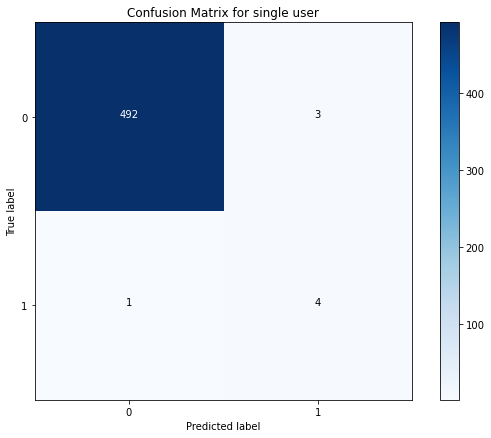

In [45]:
plot_confusion_matrix(cm=aa,
                      target_names = ['0', '1'],
                      title        = "Confusion Matrix for single user")

### All users last order predictions

In [111]:
order_n=-2
for i in range(X_test.shape[0]):
    p,order = predict(model,X_test[i],h)
    
    y_test1=y_test[i].reshape(100,-1)
    p[p > 0.03] = 1
    p[p < 0.03] = 0
    y_test1 = np.array(y_test1)
    p = np.array(p)
    print(i)
    print(confusion_matrix(y_test1[order_n], p[order_n]))

0
[[494   0]
 [  5   1]]
1
[[491   0]
 [  7   2]]
2
[[489   2]
 [  6   3]]
3
[[469   1]
 [ 28   2]]
4
[[491   3]
 [  6   0]]
5
[[495   2]
 [  3   0]]
6
[[486   4]
 [ 10   0]]
7
[[489   1]
 [  7   3]]
8
[[485   3]
 [ 12   0]]
9
[[488   6]
 [  6   0]]
10
[[496   1]
 [  3   0]]
11
[[493   0]
 [  6   1]]
12
[[491   1]
 [  6   2]]
13
[[480   1]
 [ 16   3]]
14
[[480   1]
 [ 16   3]]
15
[[479   2]
 [ 16   3]]
16
[[481   0]
 [ 18   1]]
17
[[500]]
18
[[493   2]
 [  5   0]]
19
[[492   2]
 [  4   2]]
20
[[491   2]
 [  7   0]]
21
[[489   3]
 [  7   1]]
22
[[488   5]
 [  6   1]]
23
[[484   0]
 [ 10   6]]
24
[[495   1]
 [  4   0]]
25
[[487   2]
 [  8   3]]
26
[[476   2]
 [ 20   2]]
27
[[487   0]
 [ 11   2]]
28
[[491   5]
 [  3   1]]
29
[[481   2]
 [ 14   3]]
30
[[475   1]
 [ 21   3]]
31
[[486   2]
 [  8   4]]
32
[[486   3]
 [ 10   1]]
33
[[488   4]
 [  8   0]]
34
[[476   2]
 [ 20   2]]
35
[[486   6]
 [  8   0]]
36
[[481   2]
 [ 15   2]]
37
[[488   0]
 [ 11   1]]
38
[[490   5]
 [  5   0]]
39
[[487   

313
[[491   0]
 [  8   1]]
314
[[497   2]
 [  1   0]]
315
[[480   2]
 [ 14   4]]
316
[[484   5]
 [  7   4]]
317
[[494   2]
 [  4   0]]
318
[[488   0]
 [  8   4]]
319
[[493   5]
 [  2   0]]
320
[[492   7]
 [  1   0]]
321
[[483   3]
 [ 10   4]]
322
[[494   3]
 [  3   0]]
323
[[488   1]
 [  8   3]]
324
[[485   2]
 [ 11   2]]
325
[[491   2]
 [  4   3]]
326
[[493   2]
 [  5   0]]
327
[[481   1]
 [ 15   3]]
328
[[470   1]
 [ 27   2]]
329
[[493   1]
 [  6   0]]
330
[[491   2]
 [  7   0]]
331
[[496   1]
 [  2   1]]
332
[[493   1]
 [  6   0]]
333
[[488   2]
 [ 10   0]]
334
[[484   0]
 [ 15   1]]
335
[[490   6]
 [  4   0]]
336
[[486   2]
 [ 12   0]]
337
[[493   0]
 [  5   2]]
338
[[491   1]
 [  6   2]]
339
[[478   7]
 [ 15   0]]
340
[[478   3]
 [ 18   1]]
341
[[491   7]
 [  2   0]]
342
[[492   3]
 [  3   2]]
343
[[479   6]
 [ 13   2]]
344
[[495   2]
 [  3   0]]
345
[[490   3]
 [  5   2]]
346
[[490   4]
 [  5   1]]
347
[[495   0]
 [  4   1]]
348
[[491   7]
 [  2   0]]
349
[[492   5]
 [  1   2]]
3

In [48]:
#from sklearn.metrics import confusion_matrix
#for i in range(len(y_test1)):
    #print(list(set(actual[i])-set(predicted[i])))
    #print(list(set(predicted[i])-set(actual[i])))
    #print(list(set(actual[i]).intersection(predicted[i])))
    #print(confusion_matrix(y_test1[i], p[i]))

In [343]:
#for i in range(y_test1.shape[0]):
#    print([j for j,v in enumerate(y_test1[i]) if v == 1])    